In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/My_model/pytorch-forecasting-master')


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep 29 05:34:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
!pip uninstall tensorflow
!pip install pytorch_lightning

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220719082949.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 5.0 MB/s 
     |████████████████████████████████| 419 kB 43.8 MB/s 
     |████████████████████████████████| 5.9 MB 51.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: te

In [6]:
#from ctypes import FormatError
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os,sys

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM')))

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data')))
# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\data\demand_data')))



from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_forecasting.metrics import SMAPE, RMSE
from torchmetrics import R2Score, SymmetricMeanAbsolutePercentageError, MeanSquaredError

import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import os,sys
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import operator
import statsmodels.api as sm
from itertools import combinations
import pickle
from pytorch_forecasting import Baseline
import random
from pytorch_forecasting import DeepAR,NegativeBinomialDistributionLoss
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
"""
Set Random seed
"""

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [8]:
import os
os.chdir('/content/drive/MyDrive/My_model/pytorch-forecasting-master/1_cluster_demand_prediction')

In [9]:
"""
Import pre-processed Data

response and target are the same thing
"""
with open("final_response_ts.pkl",'rb') as f:
    final_response_ts = pickle.load(f)

with open("final_num_covariate_ts.pkl",'rb') as f:
    final_num_covariate_ts = pickle.load(f)

with open("final_cat_covariate_ts.pkl",'rb') as f:
    final_cat_covariate_ts = pickle.load(f)

###### concatenate response and covariate time series into a single dataframe  #########
df3 = pd.DataFrame(final_response_ts) # response and target are the same thing
df4 = pd.DataFrame(final_num_covariate_ts)
df5 = pd.DataFrame(final_cat_covariate_ts)
df6 = pd.concat([df4,df5], axis=1) # dataframe of all covariates

df1 = pd.DataFrame({"time_idx":np.arange(0,len(df3))})
df2 = pd.DataFrame({"group":np.tile(0,len(df3))}) # identifies the series in case of univariate and multivariate series
df = pd.concat([df1,df2,df3], axis=1)
###### concatenate response and covariate time series into a single dataframe  #########


#################### add date information ts ####################
df["date"] = pd.Timestamp("2021-09-24") + pd.to_timedelta(df.time_idx, "H")
df['_hour_of_day'] = df["date"].dt.hour.astype(str)
df['_day_of_week'] = df["date"].dt.dayofweek.astype(str)
df['_day_of_month'] = df["date"].dt.day.astype(str)
df['_day_of_year'] = df["date"].dt.dayofyear.astype(str)
df['_week_of_year'] = df["date"].dt.weekofyear.astype(str)
df['_month_of_year'] = df["date"].dt.month.astype(str)
df['_year'] = df["date"].dt.year.astype(str)
#################### add date information ts ####################

Target = list(final_response_ts.keys())[0] # response and target are the same thing

tr_stop_idx = int(0.77*len(df3))
val_stop_idx = tr_stop_idx + int(0.077*len(df3)) + 25
tes_stop_idx = len(df3)

cat_col1 = list(final_cat_covariate_ts.keys())[0] # for column name agnostic
cat_col2 = list(final_cat_covariate_ts.keys())[1] # for column name agnostic
cat_col3 = list(final_cat_covariate_ts.keys())[2] # for column name agnostic
cat_col4 = list(final_cat_covariate_ts.keys())[3] # for column name agnostic

num_cols_list = list(final_num_covariate_ts.keys())[:3] # for column name agnostic
#num_cols_list.append(Target) # for column name agnostic

In [10]:
"""
set inputs here
(hyperparameters grid search)

"""
######### Network Architecture ###################

###### Create hyperparameters grid ###### 
# After tuning replace the list with the single best hparams value inside list
hparams_grid = {"LSTM_neuron_size":[168,240,320,480],
	            "num_layers":[2],
                "batch_size":[2,4],
                "learning_rate":[0.1],
                "max_encoder_length":[168],
                "max_prediction_length":[24],
                "dropout":[0.3],
	            "Num_epochs":[20],
                "df_cov1":list(df6.columns),
                "df_cov2":list(df6.columns)}
#"activation_functions":[],
###### Create hyperparameters grid ###### 

p = 10 # patience no. of epochs

Loss=NegativeBinomialDistributionLoss()

######### Network Architecture ###################




######### Training Routine ###################
fdv_steps = 10 # fast_dev_run
######### Training Routine ###################


############## Inputs for 2) Persistance model ( seasonal naive forecast ) #######################
season_len = 168 # length of season
num_past_seas = 6 # number of past seasons to use in averaging
seas_pred_strt_idx = 2038 # seasonal naive forecast start index, in hours use the df dataframe
############## Inputs for 2) Persistance model ( seasonal naive forecast ) #######################


param_comb_cnt=0
for neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2 in product(*[x for x in hparams_grid.values()]):
    param_comb_cnt+=1
param_comb_cnt

392

In [11]:
val_stop_idx

1870

In [12]:
"""
Data loading sanity check

"""

######## View the entire data using this code ##################
#print(train_dataset.data['categoricals'])
######## View the data entire using this code ##################

######## View the data for each batch using this code ##################
# for x,y in iter(train_dataloader):
#     print(x["encoder_cat"][0][0:72,2])
#     break
######## View the data for each batch using this code ##################


'\nData loading sanity check\n\n'

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK:

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

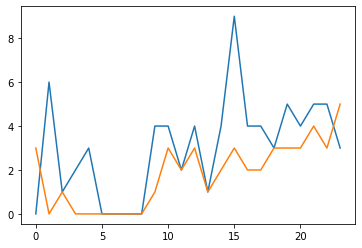

RMSE :  2.336307628146031


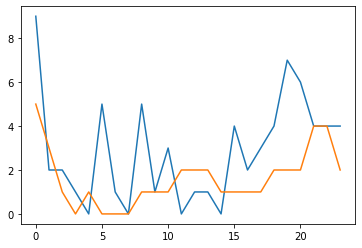

RMSE :  2.3804761428476167


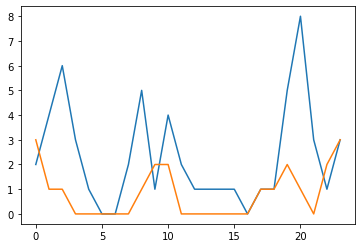

RMSE :  2.4664414311581235


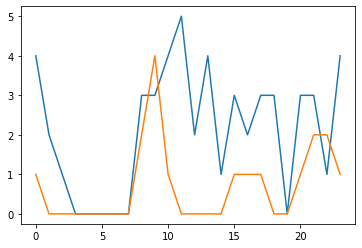

RMSE :  2.0816659994661326


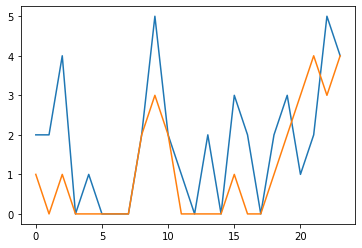

RMSE :  1.3844373104863459
Average RMSE for 5 days:  2.12986570242085

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2

346 480 2 4 0.1 168 24 0.3 20 temp_clstr_175 wind_clstr_175 



In [13]:
"""
Full Training Routine 
with hyperparmeter grid search

Load data into TimeSeriesDataSet object

for fast development run
uncomment fast_dev_run = fdv_steps

"""

#early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=p, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

RMSE_list = [] # FIND minimum RMSE case
hyperparams_list = [] # FIND minimum RMSE case

# best_val_comb_idx=[52,53,54,61,62,63,82,84,83,109,110,111,143,144,145,218,219,220,232,233,234,236,237,238,338,339,340,344,345,346]
# best_val_train_epochs = [6,6,6,15,15,15,11,11,11,10,10,10,9,9,9,5,5,5,8,8,8,8,8,8,9,9,9,10,10,10]

best_val_comb_idx=[346]
best_val_train_epochs = [10]

i=0
param_comb_cnt=0
for neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2 in product(*[x for x in hparams_grid.values()]):
    
    param_comb_cnt+=1
    if param_comb_cnt not in best_val_comb_idx:
      continue

    ######### Load DATA #############
    if df_cov_col1 == df_cov_col2:
      continue

    df[df_cov_col1] = df6[df_cov_col1].values  # add the covariate column
    df[df_cov_col2] = df6[df_cov_col2].values  # add the covariate column    
    if (df_cov_col1[:3] == 'wea' and df_cov_col2[:3] != 'wea'): 
        num_cols_list = [df_cov_col2]
        cat_col1 = df_cov_col1
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
    elif (df_cov_col2[:3] == 'wea' and df_cov_col1[:3] != 'wea'): 
        num_cols_list = [df_cov_col1]
        cat_col1 = df_cov_col2
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
    elif (df_cov_col1[:3] == 'wea' and df_cov_col2[:3] == 'wea'): 
        num_cols_list = []
        cat_col1 = df_cov_col1
        cat_col2 = df_cov_col2
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),cat_col2: NaNLabelEncoder(add_nan=True).fit(df[cat_col2]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,cat_col2,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
    else:
        num_cols_list = [df_cov_col1,df_cov_col2] # numerical covariate
        cat_dict = {"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = ["_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]

    train_dataset = TimeSeriesDataSet(
        df.iloc[0:tr_stop_idx],
        time_idx="time_idx",
        target=Target,
        categorical_encoders=cat_dict,
        group_ids=["group"],
        min_encoder_length=enc_len,
        max_encoder_length=enc_len,
        min_prediction_length=pred_len,
        max_prediction_length=pred_len,
        time_varying_unknown_reals=[Target],
        time_varying_known_reals=num_cols_list,
        time_varying_known_categoricals=cat_list,
        add_relative_time_idx=False,
        randomize_length=False,
        scalers={},
        target_normalizer=TorchNormalizer(method="identity",center=False,transformation=None )

    )

    val_dataset = TimeSeriesDataSet.from_dataset(train_dataset,df.iloc[tr_stop_idx:val_stop_idx], stop_randomization=True)
    test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,df.iloc[val_stop_idx:tes_stop_idx], stop_randomization=True)

    train_dataloader = train_dataset.to_dataloader(train=True, batch_size=bat)
    val_dataloader = val_dataset.to_dataloader(train=False, batch_size=bat)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=bat)
    ######### Load DATA #############





    """
    Machine Learning predictions START
    1) DeepAR

    """
    trainer = pl.Trainer(
        max_epochs=best_val_train_epochs[i],
        gpus=-1,
        auto_lr_find=True,
        gradient_clip_val=0.1,
        limit_train_batches=1.0,
        limit_val_batches=1.0,
        #fast_dev_run=fdv_steps,
        logger=True,
        #log_every_n_steps=10,
        # profiler=True,
        callbacks=[lr_logger]#, early_stop_callback],
        #enable_checkpointing=True,
        #default_root_dir="C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\logs"
    )
    i+=1

    #print(f"training routing:\n \n {trainer}")
    deepar = DeepAR.from_dataset(
        train_dataset,
        #learning_rate=lr,
        hidden_size=neu,
        rnn_layers=lay,
        dropout=drop,
        loss=Loss,
        log_interval=10,
        log_val_interval=3,
        log_gradient_flow=True,
        # reduce_on_plateau_patience=3,
    )

    
    ###### LOG additional hyperparameters ######
    deepar.hparams['batch_size'] = bat
    deepar.hparams['encoder_length'] = enc_len
    deepar.hparams['prediction_length'] = pred_len
    deepar.hparams['patience'] = p
    deepar.hparams['cov_1'] = df_cov_col1
    deepar.hparams['cov_2'] = df_cov_col2
    ###### LOG additional hyperparameters ######
 
    #print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")
    # print(f"Model :\n \n {deepar}")
    torch.set_num_threads(10)
    trainer.fit(
        deepar,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    ########## Prediction #####################

    test_output = deepar.predict(data=test_dataloader,mode='prediction',return_index=True,num_workers=8,show_progress_bar=True)


    RMSE_list = np.array([])
    days = 5
    for j in range(days):
      plt.plot(df[Target].iloc[2038+(j*24):2038+(j*24)+pred_len].values)
      pred = np.array(test_output[0][j*24]).astype(int)
      plt.plot(pred)
      plt.show()

      RMSE = np.sqrt(mean_squared_error(df[Target].iloc[2038+(j*24):2038+(j*24)+pred_len].values,pred ))
      print('RMSE : ',RMSE)
      RMSE_list = np.append(RMSE_list,RMSE)
    
    print(f'Average RMSE for {days} days: ',np.mean(RMSE_list))


    print('\n Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2\n')
    print(param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,'\n')
    ########## Prediction #####################
    
    # TO find minimum RMSE
    hyperparams_list.append((neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2))
    # RMSE_list.append(RMSE)

    
    ## delete this covariate column in df so that only one covariate is available 
    df.drop(df_cov_col1, axis=1, inplace=True)
    df.drop(df_cov_col2, axis=1, inplace=True)
    

    """
    Machine Learning predictions END
    """

######## Identify least RMSE case #############
# min_RMSE_idx = RMSE_list.index(min(RMSE_list))
# hyperparams_list[min_RMSE_idx]

######## Identify least RMSE case #############





In [14]:
"""
View tensorboard logs

"""


'\nView tensorboard logs\n\n'


seasonal prediction start index:  2038
 Persistance model ( seasonal naive forecast ) , sMAPE : 0.7041005492210388
 Persistance model ( seasonal naive forecast ) , RMSE : 1.9685019254684448
 Persistance model ( seasonal naive forecast ) , R2 Score : 0.21821361780166626


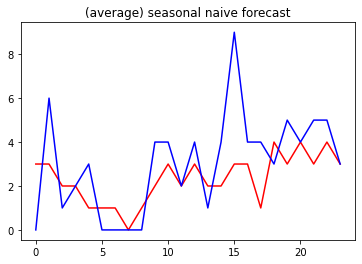


seasonal prediction start index:  2062
 Persistance model ( seasonal naive forecast ) , sMAPE : 0.7371363043785095
 Persistance model ( seasonal naive forecast ) , RMSE : 1.791182041168213
 Persistance model ( seasonal naive forecast ) , R2 Score : 0.4194156527519226


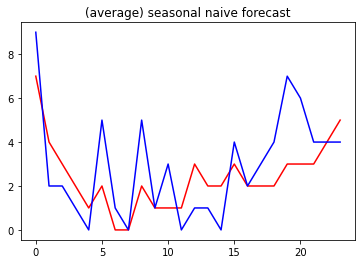


seasonal prediction start index:  2086
 Persistance model ( seasonal naive forecast ) , sMAPE : 0.4674423635005951
 Persistance model ( seasonal naive forecast ) , RMSE : 1.7795131206512451
 Persistance model ( seasonal naive forecast ) , R2 Score : 0.2348994016647339


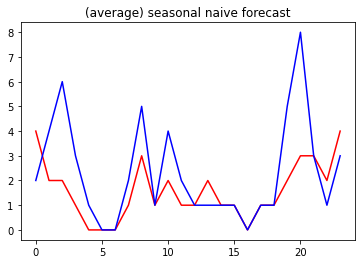


seasonal prediction start index:  2110
 Persistance model ( seasonal naive forecast ) , sMAPE : 0.5920634865760803
 Persistance model ( seasonal naive forecast ) , RMSE : 1.338531494140625
 Persistance model ( seasonal naive forecast ) , R2 Score : 0.2665244936943054


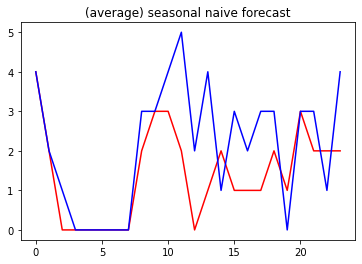


seasonal prediction start index:  2134
 Persistance model ( seasonal naive forecast ) , sMAPE : 0.604629635810852
 Persistance model ( seasonal naive forecast ) , RMSE : 0.9354143738746643
 Persistance model ( seasonal naive forecast ) , R2 Score : 0.6376707553863525


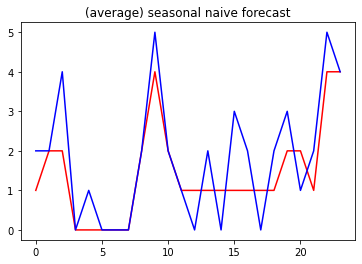

Average RMSE for 5 days:  1.5626285910606383


'\nBaseline predictions END\n'

In [15]:
    """
    Baseline predictions START
    1) Persistance model (last value)

    2) Persistance model ( seasonal naive forecast )
    """
    ############## 1) Persistance model (last value) #######################
    # actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
    # baseline_predictions = Baseline().predict(test_dataloader)
    # print(f" Persistance model (last value), sMAPE : {SMAPE()(baseline_predictions, actuals)}")
    # print(f" Persistance model (last value), RMSE : {RMSE()(baseline_predictions,actuals)}")
    # r2score = R2Score()
    # print(f" Persistance model (last value), R2 Score : { np.mean([ r2score(baseline_predictions[i], actuals[i])    for i in range(len(actuals)) ]) }" )
    ############## 1) Persistance model (last value) #######################

    ############## 2) Persistance model ( seasonal naive forecast ) #######################
    RMSE_list = np.array([])
    for j in range(days):
      predictions = np.array([])
      strt_idx = seas_pred_strt_idx+(j*24)
      actuals1 = df[Target].iloc[strt_idx:strt_idx+pred_len].values
      for h in range(24):
          sum1 = 0
          for n in range(num_past_seas):
              sum1 = sum1 + df[Target][strt_idx+h - season_len*n]
          
          predictions = np.append(predictions,sum1/num_past_seas)

      predictions = predictions.astype(int)
      actuals1 = np.array(actuals1)

      smape = SymmetricMeanAbsolutePercentageError()
      mse = MeanSquaredError()
      print(f"\nseasonal prediction start index:  {strt_idx}")
      print(f" Persistance model ( seasonal naive forecast ) , sMAPE : { smape(  torch.Tensor(predictions),torch.Tensor(actuals1))    }")
      print(f" Persistance model ( seasonal naive forecast ) , RMSE : {np.sqrt(mse(torch.Tensor(predictions),torch.Tensor(actuals1)))}")
      RMSE = np.sqrt(mse(torch.Tensor(predictions),torch.Tensor(actuals1)))
      RMSE_list = np.append(RMSE_list,RMSE)
      r2score = R2Score()
      print(f" Persistance model ( seasonal naive forecast ) , R2 Score : {r2score( torch.Tensor(predictions),torch.Tensor(actuals1)) }" )
      plt.title("(average) seasonal naive forecast")
      plt.plot(predictions,color='r')
      plt.plot(actuals1,color='b')
      plt.show()

    print(f'Average RMSE for {days} days: ',np.mean(RMSE_list))
    ############## 2) Persistance model ( seasonal naive forecast ) #######################
    """
    Baseline predictions END
    """    